In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.integrate
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
np.set_printoptions(linewidth=160)

In [2]:
mesh_x = Multidomain(Legendre(10), (0, 5, 10, 15, 20))
mesh_y = Legendre(10, (0, 5))
mesh = mesh_x*mesh_y

In [3]:
def kin_energy(v):
    return (v*v).int()/2

def pot_energy(u):
    du_dx = u.diff(0)
    du_dy = u.diff(1)
    return (du_dx*du_dx + du_dy*du_dy).int()/2

def energy(u, v):
    return kin_energy(v) + pot_energy(u)

def compress(u, v):
    return np.stack((u.func, v.func)).ravel()

def decompress(y):
    func_u, func_v = y.reshape(2, *mesh.shape)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    return u, v

def derivative(t, y):
    u, v = decompress(y)
    du_dt = v
    
    du = u.grad()
    bval = (-f(t), 0*f(t)), (0, 0)
    d2u = du.div(bval)
    d2u = d2u.match_domains()
    
    dv_dt = d2u
    
    return compress(du_dt, dv_dt)

In [4]:
def f(t):
    return 0
matrix_size = 2*np.prod(mesh.shape)
A = np.zeros((matrix_size, matrix_size))
for i, y in enumerate(Progress(np.eye(matrix_size))):
    A[:,i] = derivative(0, y)
e = np.linalg.eigvals(A)
print(np.abs(e.real).max())
print(np.abs(e.imag).max())

HTML(value='')

2.1588408007753727e-07
19.965911791862926


# 2D wave equation with impact

In [5]:
tau = 1.0
t0 = -10*tau
t_max = 50.0
dt = 1.0
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, np.zeros(mesh.shape))
v0 = TensorField(mesh, np.zeros(mesh.shape))

U = TensorField(mesh, np.zeros((len(T),) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T),) + mesh.shape))
E = np.zeros(len(T))

X, Y = mesh.grid()

def f(t):
    return np.exp(-t**2/2/tau**2)*(Y - (Y.max() + Y.min())/2)

def theory(t, x):
    return np.sqrt(np.pi/2)*tau*sp.special.erfc((x - t)/tau/np.sqrt(2))

In [6]:
%timeit derivative(t0, compress(u0, v0))

578 µs ± 859 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%time
r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

CPU times: user 2.85 s, sys: 0 ns, total: 2.85 s
Wall time: 2.85 s


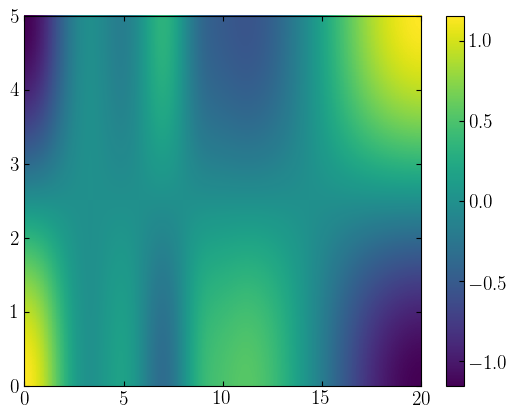

In [8]:
t = t_max
k = np.argmin(np.abs(T - t))
u = U[k]
t = T[k]
x = np.linspace(*mesh_x.endpoints, 500)
y = np.linspace(*mesh_y.endpoints, 500)
heatmap(x, y, u(x, y))
plt.colorbar()
plt.show()

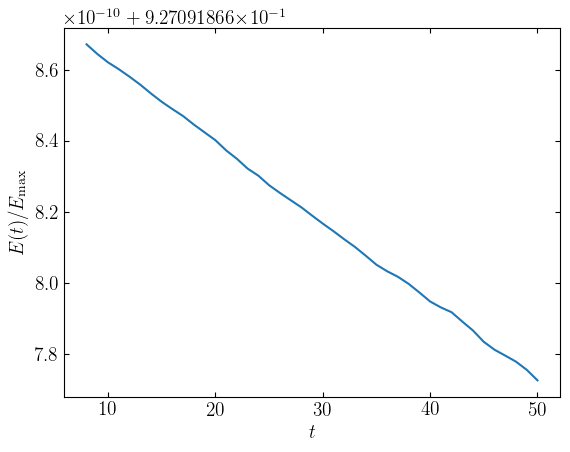

In [9]:
plt.plot(T[T>7*tau], E[T>7*tau]/E.max())
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)/E_{\rm max}$')
plt.show()

# Check precisely the energy conservation

In [31]:
%%time
t0 = 0
t_max = 1.0
dt = 0.1
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, np.random.randn(*mesh.shape))
v0 = TensorField(mesh, 0*np.random.randn(*mesh.shape))

U = TensorField(mesh, np.zeros((len(T),) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T),) + mesh.shape))
E = np.zeros(len(T))

def f(t):
    return 0

r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

CPU times: user 66.8 ms, sys: 1 ms, total: 67.8 ms
Wall time: 68.8 ms


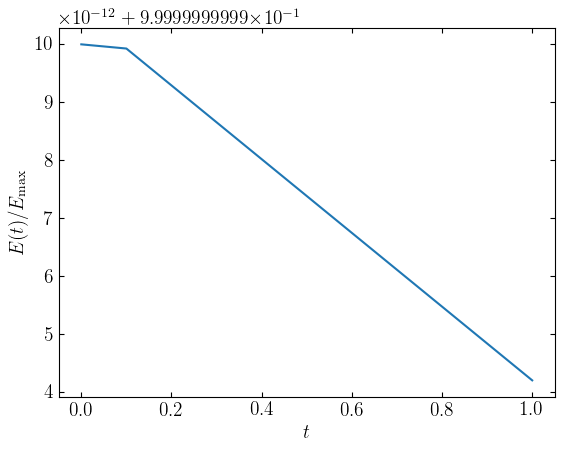

In [32]:
plt.plot(T, E/E.max())
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)/E_{\rm max}$')
plt.show()